# PM- Evapotranspiration Estimotor for Deficit Estimation

## Version history

#### Version 1.0
- First draft made 2024-04-10

#### Version 1.1
- Branch made 2024-04-12
- [get_weather] Synoptic API included into the system to download data automatically (2024-05-16)
- [get_irrlog]  Can read Irrigation log file in the root directory ('Irrigation_log.xlsx')
- [main block]  Output files are saved in individual directories
- [main block]  Final results will be saved as 'Penman_irrigation_results.csv' in the root directory
- [cal_rz]      rootzone calculation is in linear form
***
#### Version 1.2
- Branch made 2024-05-19
- [get_Mesonet] It was found that Synoptic API could have an error for downloading the data. And as a alternative.(2024-06-17)\
You can use the downloaded weather data from the Mesonet web UI [https://ag.purdue.edu/indiana-state-climate/purdue-mesonet/purdue-mesonet-data-hub/]\
Make sure this Mesonet data is ___`in 30-min interval`___ (2024-06-17)
- [hly2dly] Unit conversion added (from mile/hour to meter/second) (2024-06-18)
- [get_deficit] It should consider rainfed plot (without any irrigation/fertigagtion)\
This update made 6 new variables `[CRWL/SRWL/CRWD/SRWD/CRWDP/SRWDP]`
***
#### Version 2.0
- After 2024-06-19 Team meeting
##### Version 2.0.1
- Branch made 2024-06-18
- get_UF function testing @ ./Data_backup/UF_testing_DK.ipynb (2024-06-24)
##### Version 2.0.2
###### _PENDING_
###### _DONE_
- [get_UF] get_UF function imported to the main code (2024-06-25)
- [Root Directory] All the directory is cleaned and this script will be run in the root directory.
- [get_deficit_graph] A new function added to create a graph of the deficit in timeseries. (2024-06-26)
- [get_deficit_graph] The graph will show the recent 7 days data from today (2024-06-27)

##### Version 2.0.3
###### _PENDING_
###### _DONE_
- [get_deficit_graph] The graph unit changed into '%' (2024-06-28)
- [get_deficit] if the deficit is negative, it becomes zero
```python
    dlydata['CIWD (inch)'] = dlydata['CIWD (inch)'].apply(lambda x: 0 if x < 0 else x)
```
- [get_deficit_graph] The graph time range changed to 14 days (2024-06-28)
- [get_deficit_graph] The graph is changed to show checkbook values and observation value from './06_Deficit_results/Corn_deficit_report.csv, Soybean_deficit_report.csv (2024-06-28)
- [get_deficit] if the deficit of the day is negative, it will be 0 (2024-06-28)
<br/>

***
***

<br/>

> Before starting, give me the crop variables such as :: 
> - Date of the `Emergence` of the crop (Corn/Soybean)
> - Root zone maximum depth (Corn/Soybean)
> - 


In [1]:
Version = '  Version 2.0.3  '
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#*################ Mendatory Parameters ################*#
# transmitter info
CITRS = ['0630','0557'] # Corn Irrigation Transmitter IDs
CFTRS = ['0556','0629'] # Corn Fertigation Transmitter IDs
CRTRS = ['0554','0558'] # Corn Rainfed Transmitter IDs
SITRS = ['0112','0114'] # Soybean Irrigation Transmitter IDs
SFTRS = ['0113','0116'] # Soybean Fertigation Transmitter IDs
SRTRS = ['0111','0115'] # Soybean Rainfed Transmitter IDs

TRS_dic = {'CI':['0630','0557'],'CF':['0556','0629'],'CR':['0554','0558'],'SI':['0112','0114'],'SF':['0113','0116'],'SR':['0111','0115']}
'''
For the year 2024 Field season,
Planted:  Corn = 5/4, Soybean = 5/14
Emergence: Corn = 5/11, Soybean = 5/21
'''
CED = pd.Timestamp(2024, 5, 11) # Corn Emergence Date
SED = pd.Timestamp(2024, 5, 21) # Soybean Emergence Date

CRZMD = 24 # Corn Root Zone Max Depth (in)
CRZMDW = 7 # Week of Corn reaches Root Zone Max Depth (at the end of the week)
CRZI = 4 # Corn Root Zone Initial Depth (in)
CRZIW = 1 # Week of Corn reaches Root Zone Initial Depth

SRZMD = 24 # Soybean Root Zone Max Depth (in)
SRZMDW = 7 # Week of Soybean reaches Root Zone Max Depth (at the end of the week)
SRZI = 4 # Soybean Root Zone Initial Depth (in)
SRZIW = 1 # Week of Soybean reaches Root Zone Initial Depth

IRRATE = 0.0456 # Irrigation Rate (in/hr)

#*################ Mendatory Parameters ################*#

# get today's date as string
from datetime import date
todate = date.today().strftime("%Y-%m-%d")
today = date.today().strftime("%Y%m%d")

# Get today's date as datetime
TDY = pd.Timestamp.today()
TWK = TDY.isocalendar().week
# Corn Week From Emergence
Cweek = CED.isocalendar().week
CWPE = TWK - Cweek  # Corn Week From Emergence
# Soybean Week From Emergence
Sweek = SED.isocalendar().week
SWPE = TWK-Sweek  # Soybean Week From Emergence


print(Version.center(60,'='),end='\n')
print('Run date :', todate, '( Week:', TWK,')')
print('Week Past Emergency')
print('Corn =', CWPE, 'weeks  :  Soybean =', SWPE, 'weeks')

=====================  Version 2.0.3  ======================
Run date : 2024-06-29 ( Week: 26 )
Week Past Emergency
Corn = 7 weeks  :  Soybean = 5 weeks


### Synoptic API
https://docs.synopticdata.com/services/code-examples

#### Automated downloading system

### Function: get_weather()

**Description:**  
This function retrieves weather data from the Synoptic Data API and writes it to a CSV file.

**Imports:**  
Various modules are imported to handle HTTP requests, JSON data, CSV file writing, and date formatting.

**API Details:**  
The base

 URL

 (`API_ROOT`), API token (`API_TOKEN`), and station ID (`STID`) for the Synoptic Data API are defined.

**Date:**  
The current date is retrieved and formatted as a string (`today`).

**API Request:**  
A dictionary of API parameters (`api_arguments`) is defined, including the API token, station ID, units, timezone, start and end times, and time format. An HTTP GET request is made to the API with these parameters, and the response is converted to a JSON object (`api_raw_data`).

**Data Inspection:**  
The keys of the 'STATION' and 'OBSERVATIONS' sections of the API response are printed, as well as the units of the data.

**Data Extraction:**  
The 'OBSERVATIONS' section of the API response is extracted to `api_obs_data`.

**Returns:**  
This function does not return a value; its purpose is to write the API data to a CSV file.

In [2]:
def get_weather(filename, startdate):

    import urllib.request as req
    import os.path
    import json
    import requests
    import os
    import csv

    print('Getting Weather Data from Synoptic API')
    print('Data from :', startdate, '    to:', today)
    API_ROOT = "https://api.synopticdata.com/v2/stations/timeseries"
    API_TOKEN = "2e206cb80ead43a99afea07cb78908bb"
    STID='PDU01'
    startdate = startdate.strftime("%Y%m%d")+'1800'
    enddate = today+'1000'


    api_request_url = API_ROOT
    api_arguments = {"token":API_TOKEN,"stid":STID,"units":"english","obtimezone":"local", "start":startdate, "end":enddate, "timeformat":"%Y-%m-%d %H:%M"}
    req = requests.get(api_request_url, params=api_arguments)
    # ! Converting the data to a dictionary
    api_raw_data = req.json()

    print("===================== PLEASE CHECK THE UNITS BELOW =====================")
    for keys,values in api_raw_data['UNITS'].items():
        print(keys, ':', values)
    print("=========================================================================")
    
    # * Extracting the OBSERVATION data from the dictionary
    api_obs_data = api_raw_data['STATION'][0]['OBSERVATIONS']


    # * Writing the data to a CSV file
    with open(filename, "w", newline="\n") as f:
        # pass the csv file to csv.writer.
        writer = csv.writer(f, delimiter=',')
        
        # convert the dictionary keys to a list
        key_list = list(api_obs_data.keys())
        
        # find the length of the key_list
        limit = len(api_obs_data['date_time'])
        
        # the length of the keys corresponds to
        # no. of. columns.
        writer.writerow(api_obs_data.keys())
        
        # iterate each column and assign the
        # corresponding values to the column
        for i in range(limit):
            writer.writerow([api_obs_data[x][i] for x in key_list])



## 1. Weather conversion from hourly to daily
***
## Function: read_hly()

This function reads a tab-separated, encoded file into a pandas DataFrame, performs some preprocessing, and returns the DataFrame.

### Parameters

- `file` (str): The path to the file to be read. Downloaded from mesonet in 5-min scale.
>https://ag.purdue.edu/indiana-state-climate/purdue-mesonet/purdue-mesonet-data-hub/

### Returns

- `pandas.DataFrame`: The processed DataFrame.

### Description

The function performs the following steps:

- Reads the file, assuming it's encoded in 'utf-16' and tab-separated.
- Drops the last two columns of the DataFrame.
- Sorts the DataFrame by the 'Time (LST)' column.
- Interpolates missing values in the DataFrame using linear interpolation.
- Sets the 'Time (LST)' column as the index of the DataFrame.
- Prints the number and names of the columns in the DataFrame.
```

In [3]:
# only for reading the data as dataframe
# for reading 5-min data downloaded from MESONET
def read_hly_5min(file):
    indata = pd.read_csv(file, encoding='utf-16', sep='\t', header=1, parse_dates=[0], thousands=',',engine='python')
    indata = indata.drop(indata.columns[[-1, -2]],axis = 1)
    indata = indata.sort_values(by=['Time (LST)'])
    # TODO : interpolation method can be changed to linear. Keep tracking on this
    indata = indata.interpolate(method='ffill', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')

    
    headlist = indata.columns.values.tolist()


# for reading 5-min OR 30-min data downloaded from MESONET Synoptic API
def read_30min(file):
    indata = pd.read_csv(file, sep=',', parse_dates=[0], thousands=',', engine='python')
    # indata = indata.drop(indata.columns[[-1, -2]],axis = 1)
    
    # * Rename one columns
    # * Most of the column headers are having different name  from downloaded data from MESONET
    indata = indata.rename(columns={"date_time": "Time (LST)"})
    indata = indata.rename(columns={"air_temp_set_1": "Air Temp (°F)"})
    indata = indata.rename(columns={"relative_humidity_set_1": "Relative Humidity (%)"})
    indata = indata.rename(columns={"wind_speed_set_1": "Wind Speed (mph)"})
    indata = indata.rename(columns={"wind_gust_set_1": "Wind Gust (mph)"})
    indata = indata.rename(columns={"wind_direction_set_1": "Wind Dir (°)"})
    indata = indata.rename(columns={"pressure_set_1d": "Pressure (in)"})
    indata = indata.rename(columns={"solar_radiation_set_1": "Solar Radiation (W/m²)"})
    indata = indata.rename(columns={"precip_accum_30_minute_set_1": "Precipitation (in)"})

    indata = indata.sort_values(by=['Time (LST)'])
    indata = indata.interpolate(method='ffill', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')

    
    headlist = indata.columns.values.tolist()

    return indata

# for reading 30-min data downloaded from MESONET Webpage
def get_Mesonet():
    # * Using the downloaded data from MESONET (Daily data)
    filename = './13_Mesonet_data/Table (30-min).csv'
    # read the filename file and convert it to a dataframe
    indata = pd.read_csv(filename, header=1, encoding = "utf-16", sep='\t', thousands=',', parse_dates=[0], engine='python')
    # sort the dataframe by date
    indata = indata.sort_values(by='Time (LST)')

    indata = indata.rename(columns={"Time (LST)": "Time (LST)"})
    indata = indata.rename(columns={"Air Temp (°F)": "Air Temp (°F)"})
    indata = indata.rename(columns={"Relative Humidity (%)": "Relative Humidity (%)"})
    indata = indata.rename(columns={"Wind Speed (mph)": "Wind Speed (mph)"})
    indata = indata.rename(columns={"Wind Gust (mph)": "Wind Gust (mph)"})
    indata = indata.rename(columns={"Wind Direction (°)": "Wind Dir (°)"})
    # indata = indata.rename(columns={"pressure_set_1d": "Pressure (in)"}) # No pressure data
    indata = indata.rename(columns={"Solar Radiation (W/m²)": "Solar Radiation (W/m²)"})
    indata = indata.rename(columns={"Precipitation (in)": "Precipitation (in)"})

    indata = indata.sort_values(by=['Time (LST)'])
    indata = indata.interpolate(method='ffill', limit_direction='forward', axis=0)
    # indata = indata.interpolate(method='linear', limit_direction='forward', axis=0)
    indata = indata.set_index('Time (LST)')

    headlist = indata.columns.values.tolist()

    return indata

## Function: subhly2dly()

This function takes in a DataFrame of hourly weather data, resamples it to daily data, performs some calculations, and returns a DataFrame of daily weather data.

### usage

```python
hly2dly(indata)
```

### Parameters

- `indata` (pandas.DataFrame): The input DataFrame containing hourly weather data.

### Returns

- `pandas.DataFrame`: The processed DataFrame containing daily weather data.

### Description

The function performs the following steps:

1. Prints the information of the input DataFrame using `indata.info()`.
2. Resamples the 'Wind Speed (mph)', 'Precipitation (in)', 'Relative Humidity (%)', 'Air Temp (°F)', and 'Solar Radiation (W/m²)' columns to daily data using the mean for wind speed, relative humidity, air temperature, and solar radiation, and the sum for precipitation.
3. Renames the resampled columns.
4. Converts the precipitation from inches to millimeters and the temperature from Fahrenheit to Celsius.
5. Calculates the saturation vapor pressure using the formula provided in the `cal_svp` function.
6. Calculates the vapor pressure using the relative humidity and the saturation vapor pressure.
7. Concatenates all the calculated daily data into a new DataFrame.
8. Rounds the values in the new DataFrame to 3 decimal places.
9. Returns the new DataFrame of daily weather data.

This Python function `hly2dly` takes a DataFrame `indata` as input, which is expected to contain hourly weather data.\
The function processes this data to generate daily averages and sums for various weather parameters. Here's a step-by-step explanation:

1. `indata.info()`: Prints the information about the DataFrame `indata`.

2. `ws_avg_dly = indata['Wind Speed (mph)'].resample('D').mean()`: Resamples the 'Wind Speed (mph)' column to daily frequency by taking the mean of each day's data.\
Unit converted from mile/hour to meter/second

3. `pcpin_sum_dly = indata['Precipitation (in)'].resample('D').sum()`: Resamples the 'Precipitation (in)' column to daily frequency by taking the sum of each day's data.\
It then converts this data from inches to millimeters.

4. `rh_avg_dly = indata['Relative Humidity (%)'].resample('D').mean()`: Resamples the 'Relative Humidity (%)' column to daily frequency by taking the mean of each day's data.

5. `tf_avg_dly = indata['Air Temp (°F)'].resample('D').mean()`: Resamples the 'Air Temp (°F)' column to daily frequency by taking the mean of each day's data.\
It then converts this data from Fahrenheit to Celsius.

6. `sr_avg_dly = indata['Solar Radiation (W/m²)'].resample('D').mean()`: Resamples the 'Solar Radiation (W/m²)' column to daily frequency by taking the mean of each day's data.

7. `cal_svp(value)`: This nested function calculates the saturation vapor pressure given a temperature in Celsius.

8. `svp_dly = tc_avg_dly.apply(cal_svp)`: Applies the `cal_svp` function to the daily average temperature in Celsius to calculate the daily saturation vapor pressure.

9. `vp_dly = rh_avg_dly/100*svp_dly*10`: Calculates the daily vapor pressure using the daily average relative humidity and the daily saturation vapor pressure.

10. `dlydata = pd.concat([ws_avg_dly, pcpmm_sum_dly, sr_avg_dly, tc_avg_dly, rh_avg_dly, svp_dly, vp_dly], axis=1)`: Concatenates all the daily data into a new DataFrame.

11. `dlydata = dlydata.round(3)`: Rounds the values in the DataFrame to three decimal places.

12. `return dlydata`: Returns the final DataFrame containing the daily weather data.

Each step in the function is renaming the Series for clarity and ease of understanding when the DataFrame is returned.

In [4]:
def subhly2dly(indata):
    # print(indata.info())

    ws_avg_dly = indata['Wind Speed (mph)'].resample('D').mean()   # wind speed
    ws_avg_dly = ws_avg_dly*0.44704  # convert to meter per second
    ws_avg_dly.rename('AVG_WS (mps)', inplace=True)

    pcpin_sum_dly = indata['Precipitation (in)'].resample('D').sum()   # solar radiation
    pcpin_sum_dly.rename('precip (in)', inplace=True)
    pcpmm_sum_dly = pcpin_sum_dly*25.4  # convert to mm
    pcpmm_sum_dly.rename('precip (mm)', inplace=True)

    rh_avg_dly = indata['Relative Humidity (%)'].resample('D').mean()   # relative humidity
    rh_avg_dly.rename('AVG_RH (%)', inplace=True)

    tf_avg_dly = indata['Air Temp (°F)'].resample('D').mean()   # average temperature
    tf_avg_dly.rename('AVG_Temp (°F)', inplace=True)
    tc_avg_dly = (tf_avg_dly-32)*5/9  # convert to celsius
    tc_avg_dly.rename('AVG_Temp (°C)', inplace=True)


    sr_avg_dly = indata['Solar Radiation (W/m²)'].resample('D').mean()   # solar radiation
    sr_avg_dly.rename('SUM_SR (W/m²)', inplace=True)

    # calculate saturation vapor pressure and vapor pressure
    def cal_svp(value):
        # formula for saturation vapor pressure
        # IF(Temp>0,0.6108*EXP(17.27*Temp/(237.3+Temp)),0.6108*EXP(17.27*0.5/(237.3+0.5)))
        if value > 0:
            return np.exp(17.27*value/(237.3+value))*0.6108
        else:
            return np.exp(17.27*0.5/(237.3+0.5))*0.6108
    svp_dly = tc_avg_dly.apply(cal_svp)  # saturation vapor pressure
    svp_dly.rename('SVP (kPa)', inplace=True)

    # get the vapor pressure from saturation vapor pressure and relative humidity
    vp_dly = rh_avg_dly/100*svp_dly*10  # vapor pressure
    vp_dly.rename('VP (mb)', inplace=True)

    # combine all the data and build the daily data
    dlydata = pd.concat([ws_avg_dly, pcpmm_sum_dly, sr_avg_dly, tc_avg_dly, rh_avg_dly, svp_dly, vp_dly], axis=1)

    # update the SVP based on the VP and temperature in the daily data
    def update_svp(VP, Temp):
        # formula for updating saturation vapor pressure
        # =IF(Temp>0,0.6108*EXP(17.27*Temp/(237.3+Temp)),VP*0.1)
        if Temp > 0:
            return np.exp(17.27*Temp/(237.3+Temp))*0.6108
        else:
            return VP*0.1

    # update the SVP based on the previous day's VP and temperature
    for i, row in dlydata.iterrows():
        dlydata.at[i, 'SVP (kPa)'] = update_svp(dlydata.at[i, 'VP (mb)'], row['AVG_Temp (°C)'])


    # save the data
    dlydata = dlydata.round(4)
    outfilename = './11_Clean_Weather_data/Daily_weather_'+today+'_.csv'
    dlydata.to_csv(outfilename) 


    return dlydata



# 2. Get the parameters for P-M
Reference : https://www.fao.org/4/x0490e/x0490e06.htm
***
### 2.1 Function: get_heatflux(dlydata)

**Description:**  
This function takes a DataFrame `dlydata` as an argument and returns a modified DataFrame with two new columns: 'HeatFlux' and 'Jdate'.

**Parameters:**  
- `dlydata` (pd.DataFrame): The input DataFrame. The DataFrame's index should be a datetime index.

**Returns:**  
- `dlydata` (pd.DataFrame): The modified DataFrame with 'HeatFlux' and 'Jdate' columns. The 'HeatFlux' column represents the heat flux values corresponding to the month of each record. The 'Jdate' column represents the Julian date of each record.

1. The function takes a DataFrame `dlydata` as an argument.

2. A dictionary `heatfluxdict` is created. This dictionary maps each month (represented by numbers 1 to 12) to a specific heat flux value.

3. A new column 'Month' is added to the `dlydata` DataFrame. This column is populated with the month values extracted from the DataFrame's index.

4. Another new column 'HeatFlux' is added to the `dlydata` DataFrame. This column is populated by mapping the 'Month' column values to the corresponding heat flux values using the `heatfluxdict` dictionary.

5. The 'Month' column is then dropped from the DataFrame as it's no longer needed.

6. The DataFrame's index is converted to a Julian date and added as a new column 'Jdate'. To do this, a temporary 'J1Date' column is created representing the start of each year. The 'Jdate' is then calculated by subtracting the Julian date of 'J1Date' from the Julian date of the DataFrame's index.

7. The temporary columns 'year', 'month', 'day', and 'J1Date' are dropped from the DataFrame.

8. The function returns the modified `dlydata` DataFrame.

This function essentially enriches the input DataFrame with a 'HeatFlux' column based on the month of each record and a 'Jdate' column representing the Julian date of each record.

In [5]:
def get_heatflux(dlydata):
    # set up the heatflux dictionary
    heatfluxdict = {1: -0.05070, 2: 0.53883, 3: 0.87173, 4: 0.87282, 5: 0.74453, 6: 0.41668, 7: -0.00046, 8: -0.32468, 9: -0.68616, 10: -0.89309, 11: -0.87893, 12: -0.61055}

    # add a column 'Month' to the dlydata using the index of dlydata
    dlydata['Month'] = dlydata.index.month

    # add new column 'HeatFlux' to the dlydata using Month from the index of dlydata and mtdata dictionary
    dlydata['HeatFlux (MJ/m²/day)'] = dlydata['Month'].map(heatfluxdict)

    # drop the 'Month' column
    dlydata = dlydata.drop(columns=['Month'])

    # convert to julian date from the dlydata index
    dlydata["year"]=dlydata.index.year
    dlydata['month'] = 1
    dlydata['day'] = 1
    dlydata['J1Date']=pd.to_datetime(dlydata[["year", "month", "day"]])
    dlydata['Jdate']=dlydata.index.to_julian_date() - dlydata.J1Date.apply(pd.Timestamp.to_julian_date)
    # drop the 'year', 'month', 'day', 'J1Date' columns
    dlydata = dlydata.drop(columns=['year', 'month', 'day', 'J1Date'])
    
    return dlydata

### 2.1 Appendix Calculatae Miscellenious equations

>* Barometric Pressure\
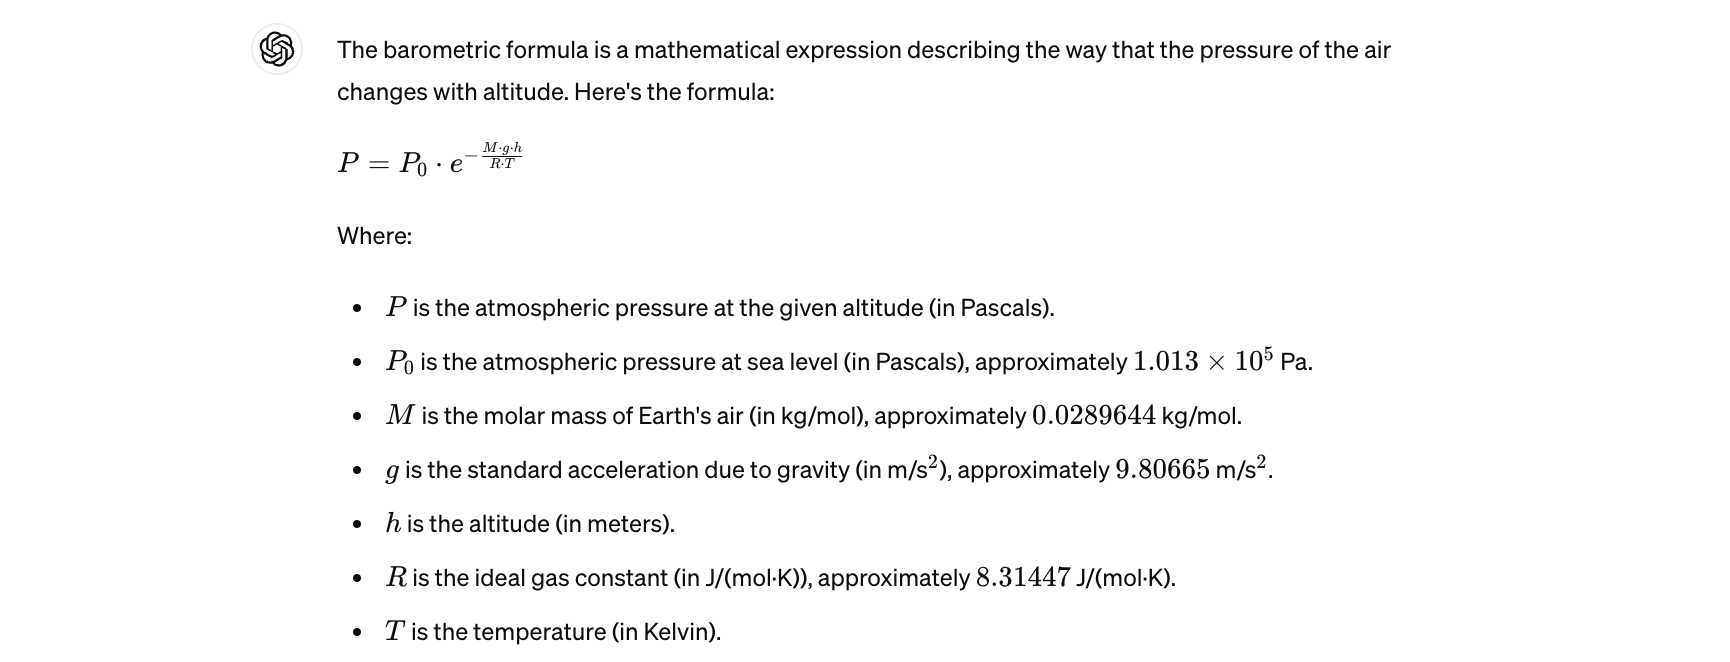\
Reference:
Wikipedia contributors. (2021, October 1). Barometric formula. In Wikipedia, The Free Encyclopedia. Retrieved 12:08, May 15, 2024, from https://en.wikipedia.org/w/index.php?title=Barometric_formula&oldid=1047003878



### 2.2 Function: PET_Penman(dlydata)

**Description:**  
This function calculates the reference evapotranspiration (ETo) using the Penman-Monteith equation and adds it as a new column to the input DataFrame.

**Parameters:**  
- `dlydata` (pd.DataFrame): The input DataFrame.

**Nested Functions:**  
The function contains several nested functions, each performing a specific calculation related to the Penman-Monteith equation for estimating evapotranspiration (ETo).

- `get_pressure(Temp)`: Calculates atmospheric pressure based on temperature and elevation.
- `get_gamma(Temp)`: Calculates the psychrometric constant (gamma) based on temperature and atmospheric pressure.
- `get_VPD(SVP, VP)`: Calculates the vapor pressure deficit (VPD) based on saturation vapor pressure (SVP) and actual vapor pressure (VP).
- `get_VPS(Temp)`: Calculates the slope of the saturation vapor pressure curve (VPS) at a given temperature.
- `get_Rnet(VP, Temp, SR, JDate)`: Calculates the net radiation (Rnet) at the crop surface.
- `get_ETo(HeatFlux, Temp, WS, VPD, Rnet, gamma, VPS)`: Calculates the reference evapotranspiration (ETo) using the Penman-Monteith equation.

**Loop:**  
The function contains a loop that iterates over each row in the `dlydata` DataFrame and applies the nested functions to calculate various parameters needed for the Penman-Monteith equation.

**New Column:**  
The function calculates the reference evapotranspiration (ETo) for each row in the `dlydata` DataFrame using the `get_ETo` function and adds it as a new column 'ETo (inch)'.

**Returns:**  
- `dlydata` (pd.DataFrame): The modified DataFrame with the new 'ETo (inch)' column.

In [6]:
def PET_Penman (dlydata):
# def PET_Penman (Wind_speed, radiation, Temp, V_Pressure, heat_Flux, j):
    import math
    
    def get_pressure(Temp):
        # Constants
        elevation = 213.36  # Elevation of the weather station (m)
        R = 8.31447  # Ideal gas constant (J/(mol·K))
        g = 9.80665  # Standard acceleration due to gravity (m/s^2)
        M = 0.0289644  # molar mass of Earth's air (kg/mol)
        # Convert temperature to Kelvin
        T = Temp + 273.15  # Convert Celsius to Kelvin
        # Calculate pressure
        pressure = (1e5) * math.exp((-g * M * elevation) / (R * T))
        
        return round(pressure/1000,3)  # Convert Pa to kPa and round to 4 decimal places

    def get_gamma(Temp):
        AP = get_pressure(Temp) # Atmospheric pressure (kPa)
        # gamma calculation
        lammbda= 2.501-Temp*0.002361 
        gamma  =0.001013*AP/(0.622*lammbda)
        return gamma
    
    def get_VPD(SVP, VP):
        # calcualate Vapor Pressure Deficit
        VPD= SVP-VP*0.1
        return VPD
    
    def get_VPS(Temp):
        # calculate Vapor Pressure Curve Slope
        VPS= 4098*0.6108*math.exp(((17.27*Temp)/(Temp+237.3)))/((Temp+237.3)**2)
        return VPS
    
    def get_Rnet(VP, Temp, SR, JDate):
        # calculate Net Radiation
        # Constants
        sigma=4.903*10**-9
        Rbo= sigma*(Temp+273)**4
        Rs= SR*60*60*24/10e5    
        dr=1+0.033*math.cos(2*math.pi*JDate/365)
        declination=0.409*math.sin((2*math.pi*JDate/365)-1.39)
        sunset_angle=math.acos(-1*math.tan(40.469794*math.pi/180)*math.tan(declination))
        Ra=(24*60*0.082/math.pi)*dr*(math.sin(40.469794*math.pi/180)*math.sin(declination)+math.cos(40.469794*math.pi/180)*math.cos(declination)*math.sin(sunset_angle))
        Rso=(213.36*0.00002+0.75)*Ra    
        Rnl=Rbo*(0.34-0.14*math.sqrt(0.1*VP))*(1.35*(Rs/Rso) - 0.35)      
        Rnet=Rs*(1-0.23)-Rnl
        
        return Rnet
    

    def get_ETo(HeatFlux, Temp, WS, VPD, Rnet, gamma, VPS):
        # Calculate ETo using Penman-Monteith equation
        ETo=(0.408*VPS*(Rnet-HeatFlux)+gamma*(900/(Temp+273))*WS*VPD)/(VPS+gamma*(1+0.34*WS))  
        ETo=ETo/25.4
        return ETo
    # return (lammbda,Sat_VP,vpd,slope,Pressure,gamma,sigma,Rbo,Rs,j,dr,declination,sunset_angle,Ra, Rso,Rnl,ETo)
    # ETo_in=ETo/25.4


    for i, row in dlydata.iterrows():
        # apply get_pressure function to each row of dlydata
        dlydata.at[i, 'AP (kPa)'] = get_pressure(dlydata.at[i,'AVG_Temp (°C)'])
        # apply get_gamma function to each row of dlydata
        dlydata.at[i, 'gamma'] = get_gamma(dlydata.at[i,'AVG_Temp (°C)'])
        # apply get_VPD function to each row of dlydata
        dlydata.at[i, 'VPD (kPa)'] = get_VPD(dlydata.at[i,'SVP (kPa)'], row['VP (mb)'])
        # apply get_VPS function to each row of dlydata
        dlydata.at[i, 'VPS (kPa/°C)'] = get_VPS(dlydata.at[i,'AVG_Temp (°C)'])
        # apply get_Rnet function to each row of dlydata
        dlydata.at[i, 'Rnet (MJ/m²/day)'] = get_Rnet(row['VP (mb)'], row['AVG_Temp (°C)'], row['SUM_SR (W/m²)'], row['Jdate'])

    #! Final Calculation of ETo
    # calculate ETo (inch) using get_ETo function  to each row of dlydata
    dlydata['ETo (inch)'] = get_ETo(dlydata['HeatFlux (MJ/m²/day)'], dlydata['AVG_Temp (°C)'], dlydata['AVG_WS (mps)'], dlydata['VPD (kPa)'], dlydata['Rnet (MJ/m²/day)'], dlydata['gamma'], dlydata['VPS (kPa/°C)'])

    
    return dlydata


## 3. Get the Crop Efficiency
***
### 3.1 Function: get_weeks_past_emergence

#### Description
This function calculates the weeks past emergence for corn and soybean crops. It modifies the input DataFrame by adding two new columns: `CWPE` and `SWPE`, which represent the weeks past emergence for corn and soybean, respectively.

#### Parameters
- `dlydata` (_pandas.DataFrame_): The input DataFrame. It should contain a datetime index and columns for the week of corn and soybean emergence (`Cweek` and `Sweek`).

#### Returns
- _pandas.DataFrame_: The modified DataFrame with two new columns: `CWPE` and `SWPE`.

#### Functionality
1. The function first calculates the current week from the datetime index of `dlydata` and stores it in a new column `Week`.
2. It then calculates the weeks past emergence for corn by subtracting `Cweek` from `Week` and adds 1. The result is stored in a new column `CWPE`.
3. If the value in `CWPE` is greater than 53, it is set to 0. This is done using the `apply` function with a lambda function that checks if the value is greater than 53.
4. The same steps are repeated for soybean, but using `Sweek` instead of `Cweek` and storing the result in a new column `SWPE`.
***
### 3.2 Function: get_ETc

#### Description
This function calculates the crop evapotranspiration for corn and soybean crops. It modifies the input DataFrame by adding two new columns: `CET (inch)` and `SET (inch)`, which represent the crop evapotranspiration for corn and soybean, respectively.

#### Parameters
- `dlydata` (_pandas.DataFrame_): The input DataFrame. It should contain columns for the average temperature (`AVG_Temp (°C)`) and the reference evapotranspiration (`ETo (inch)`).

#### Returns
- _pandas.DataFrame_: The modified DataFrame with two new columns: `CET (inch)` and `SET (inch)`.

#### Functionality
1. The function first reads the crop coefficients for corn and soybean from an Excel file named 'Crop_coefficient.xlsx', and adds two new columns to `dlydata`: `CKc` and `SKc`, which represent the crop coefficients for corn and soybean, respectively.
2. It then calculates the crop evapotranspiration by multiplying the reference evapotranspiration by the crop coefficient. The result for corn is stored in a new column `CET (inch)`, and the result for soybean is stored in a new column `SET (inch)`.
***
### 3.2.1 Function: get_rootzone / cal_rz (in step 4.2)

#### Description
This function estimates the root zone depth for corn and soybean crops. It modifies the input DataFrame by adding two new columns: `CRZ (inch)` and `SRZ (inch)`, which represent the root zone depth for corn and soybean, respectively.

#### Parameters
- `dlydata` (_pandas.DataFrame_): The input DataFrame. It should contain columns for the weeks past emergence for corn and soybean (`CWPE` and `SWPE`).

#### Returns
- _pandas.DataFrame_: The modified DataFrame with two new columns: `CRZ (inch)` and `SRZ (inch)`.

#### Functionality
1. The function first defines two nested functions `cal_crz` and `cal_srz` to calculate the root zone depth for corn and soybean, respectively. These functions calculate the root zone depth based on the weeks past emergence and the root zone growth rate.
2. If the weeks past emergence is less than the week of root zone initiation, the root zone depth is set to the initial root zone depth.
3. If the weeks past emergence is greater than the week of maximum root zone depth, the root zone depth is set to the maximum root zone depth.
4. Otherwise, the root zone depth is calculated as the previous day's root zone depth plus the daily root zone growth rate.
5. The calculated root zone depths for corn and soybean are added to the `dlydata` DataFrame in new columns `CRZ (inch)` and `SRZ (inch)`, respectively.


In [7]:
def get_weeks_past_emergence(dlydata):
    # Calculate week past emergence by substracting CED, SED from datetime index of dlydata
    # get a new column of current week from datetime index of dlydata
    dlydata['Week'] = dlydata.index.to_series().dt.isocalendar().week
    # get the week past emergence for corn
    dlydata['CWPE'] = dlydata['Week'] - Cweek + 1
    # filter the CWPE/SWPE and if value is bigger than 53, make it 0
    dlydata['CWPE'] = dlydata['CWPE'].apply(lambda x: 0 if x > 53 else x)
    
    # get the week past emergence for soybean
    dlydata['SWPE'] = dlydata['Week'] - Sweek + 1
    # filter the CWPE/SWPE and if value is bigger than 53, make it 0
    dlydata['SWPE'] = dlydata['SWPE'].apply(lambda x: 0 if x > 53 else x)

    return dlydata


def get_ETc(dlydata):
    # get the crop coefficient for corn and soybean from excel file named 'Crop_coefficient.xlsx' from ../15_Crop_data folder
    # read the excel file and get corn crop coefficient
    ckcdata = pd.read_excel('./15_Crop_data/Crop_coefficient.xlsx', sheet_name='corn', index_col=0)
    skcdata = pd.read_excel('./15_Crop_data/Crop_coefficient.xlsx', sheet_name='soybean', index_col=0)

    for i, row in dlydata.iterrows():
        # get the row from ckcdata using the week from dlydata['Week'] as temp_wk and temperature from dlydata['AVG_Temp (°C)'] as temp_val
        # will be used to index the kcdatas'
        temp_wk = dlydata.at[i, 'CWPE']  # get the corn week past emergence from dlydata
        temp_val = dlydata.at[i, 'AVG_Temp (°C)']   # get the temperature from dlydata
        # make temp_val 50 if less than 50 in inline if statement and round up to 10th decimal place at the same time
        temp_val = 50 if int(round(temp_val,-1)) < 50 else int(round(temp_val,-1))
        # index the ckcdata using temp_val and temp_wk
        dlydata.at[i, 'CKc'] = ckcdata.at[temp_val, temp_wk]

    for i, row in dlydata.iterrows():
        # get the row from ckcdata using the week from dlydata['Week'] as temp_wk and temperature from dlydata['AVG_Temp (°C)'] as temp_val
        # will be used to index the kcdatas'
        temp_wk = dlydata.at[i, 'SWPE']  # get the soybean week past emergence from dlydata
        temp_val = dlydata.at[i, 'AVG_Temp (°C)']   # get the temperature from dlydata
        # make temp_val 50 if less than 50 in inline if statement and round up to 10th decimal place at the same time
        temp_val = 50 if int(round(temp_val,-1)) < 50 else int(round(temp_val,-1))
        # index the ckcdata using temp_val and temp_wk
        dlydata.at[i, 'SKc'] = skcdata.at[temp_val, temp_wk]

    # calculate the ETc for corn and soybean
    dlydata['CET (inch)'] = dlydata['ETo (inch)']*dlydata['CKc']
    dlydata['SET (inch)'] = dlydata['ETo (inch)']*dlydata['SKc']
    
    return dlydata


def get_rootzone(dlydata):
    # estimate the rootzone depth for corn and soybean
    # there are three conditions to be met to estimate the rootzone depth
    # 1. Corn/Soybean week from emergence should be greater than the week of root zone initiation, if not root zone depth is CRZI/SRZI
    # 2. Corn/Soybean week from emergence should be less than the week of root zone max depth
    # 3. if condition 1,2 are satisfied, then daily root zone growth rate is calculated as (CRZMD-CRZI)/(CRZMDW-1)*7 or (SRZMD-SRZI)/(SRZMDW-1)*7
    # 4. current root zone depth is calculated as previous day root zone depth + daily root zone growth rate

    # making a nest function to calculate the root zone depth with if else statement
    def cal_crz():
        try:    # try to get the previous day's SRZ value
            crz = dlydata.at[i-pd.Timedelta(days=1), 'CRZ (inch)']
        except:
            crz = CRZI
        if dlydata.at[i, 'CWPE'] <= CRZMDW:
            if dlydata.at[i, 'CWPE'] > CRZIW:
                return crz + (CRZMD-CRZI)/((CRZMDW-CRZIW)*7)
            else:
                return CRZI
        else:
            return CRZMD

    def cal_srz():
        try:    # try to get the previous day's SRZ value
            srz = dlydata.at[i-pd.Timedelta(days=1), 'SRZ (inch)']
        except:
            srz = SRZI
        if dlydata.at[i, 'SWPE'] <= SRZMDW:
            if dlydata.at[i, 'SWPE'] > SRZIW:
                return srz + (SRZMD-SRZI)/((SRZMDW-SRZIW)*7)
            else:
                return SRZI
        else:
            return SRZMD
    '''
    # iterate cal_crz/cal_srz funtion over the dlydata to calculate the root zone depth for corn and plug the return value to a new column 'CRZ'
    for i, row in dlydata.iterrows():
        dlydata.at[i, 'CRZ (inch)'] = cal_crz()
        dlydata.at[i, 'SRZ (inch)'] = cal_srz()
    '''
    
    
def cal_rz():
    # this program is using linear group root growth rate
    # get the root zone depth for corn and soybean
    # get the days from emergence until the index date of dlydata (CDFE/SDFE)
    CDFE = (dlydata.index - CED).days
    SDFE = (dlydata.index - SED).days
    
    # root zone growth rate of corn (CRZGR/SRZGR) = CDFE*(CRZMD-CRZI)/(CRZMDW-1)*7 (inch/day)
    CRZGR = (CRZMD-CRZI)/((CRZMDW-1)*7)
    print('Corn root growth rate (CRZGR):', CRZGR)
    SRZGR = (SRZMD-SRZI)/((SRZMDW-1)*7)
    print('Soybean root growth rate (SRZGR):', SRZGR)

    # calculate the root zone depth for corn and soybean
    # if (CRZ/SRZ) is lower than CRZI/SRZI, then CRZ/SRZ is CRZI/SRZI
    
    dlydata['CRZ (inch)'] = CRZI + CDFE*CRZGR
    dlydata['SRZ (inch)'] = SRZI + SDFE*SRZGR

    # if CRZ/SRZ is below CRZI/SRZI, then CRZ/SRZ is 0
    # this is because the date is before the emergence date
    dlydata['CRZ (inch)'] = dlydata['CRZ (inch)'].apply(lambda x: 0 if x < CRZI else x)
    dlydata['SRZ (inch)'] = dlydata['SRZ (inch)'].apply(lambda x: 0 if x < SRZI else x)
    dlydata['CRZ (inch)'] = dlydata['CRZ (inch)'].apply(lambda x: CRZMD if x > CRZMD else x)
    dlydata['SRZ (inch)'] = dlydata['SRZ (inch)'].apply(lambda x: SRZMD if x > SRZMD else x)


    return dlydata

### 3.3 Get the Soil Moisture data for the Upward Flux
***
#### Functions:
For downloading the soil moisture data:
- getCustomerDevices
- get_keys
- get_data_chunk
- get_data
- outputCSV
- getDeviceCredentialsByDeviceId
- getDeviceServerAttributes

For calculating Upward Flux (UF):
- read_L4df
- get_UF

#### Description
This function is for getting the UF values for water loss and deficit calculation.

#### Parameters
[read_L4df]
- `filename` name of the input file downloaded from the thingsboard\
in this script, it is below:
```python
        f"./04_Soilmoisture_data/SM-Layer4_{today}.csv"
```
[get_UF]
- `UFdf` name of the dataframe that returned from `read_L4df` function.

#### Returns
- `UFdf, UFdf2` calculated results of the upward flux for each crop/managements


In [8]:
# // this part is download the data from the website for 2 month.
import requests
import sys
import os
import json
import pandas as pd
from pprint import pprint
import datetime
import pytz
# import config  # I don't know what is this config but this is meaningless DK 2024-06-24
from dateutil.relativedelta import relativedelta

deviceList = []

# ** set the configuration for the request                                                                                  **
config = {
 'username' : 'yang2309@purdue.edu', ### Insert your email address used by AgIT Thingsboard system
 'password': 'dsya2002',  ### Insert your AgIT thingsboard password
 'server' : 'https://things.iot.ag.purdue.edu:8080'
}

# ** defining the function to get the token for the request and setting the header for the request                          **
def getCustomerDevices(custID, textSearch=None):
    parameters = {        
        'pageSize': 1000,
        'page': 0,                
    }
    att_parms = {
        'keys': 'dev_eui'
    }
    if(textSearch):
        parameters.update({'textSearch': textSearch})
    responseList = requests.get(f"{config['server']}/api/customer/{custID}/devices", headers=TBheaders,params= parameters).json()
    #pprint(responseList)
    list = []
    for dev in responseList['data']:
        #pprint(dev)
        #print('------------------------------------------------------------------------------------------')
        #'id': {'entityType': 'DEVICE', 'id': 'd49153a0-c868-11eb-95d8-09d06ef6a9a5'},
        url = f"{config['server']}/api/plugins/telemetry/DEVICE/{dev['id']['id']}/values/attributes"
        deviceResp = requests.get(url, headers=TBheaders,params= att_parms).json()
        #print('------------------------------------------------------------------------------------------')
        list.append([dev['id']['id'],dev['name'],deviceResp[0]['value']])
    return list
        

def login(url, username, password):
    # Log into ThingsBoard
    return requests.post(f"{url}/api/auth/login", json={
        "username": username,
        "password": password
    }).json()['token']

def get_keys(device):
    return requests.get(f"{config['server']}/api/plugins/telemetry/DEVICE/{device}/keys/timeseries",
                 headers=TBheaders).json()
def get_data_chunk(url, token, device, key, start, stop, limit):
    #print([url, device, key, start, stop, limit])
    return requests.get(f"{url}/api/plugins/telemetry/DEVICE/{device}/values/timeseries",
             headers=TBheaders,
            params= {
                'keys': key,
                'startTs': start,
                'endTs': stop,
                'limit': limit,
                'agg': 'NONE'
            }).json()

def get_data(url, token, device, key, start, stop):
    global totalLength
    p = pd.DataFrame()
    
    # You have to request data backwards in time ...
    while start < stop:
        data = get_data_chunk(url, token, device[0], key, start, stop, 100000)
        #print(data)
        if key not in data:
            break;
        
        #print(f"{key}: Loaded {len(data[key])} points")
        t = pd.DataFrame.from_records(data[key])
        #t['Timestamp'] = t['ts']
        #pprint(t['ts'])
        t['ts'] = (pd.to_datetime(t['ts'],unit='ms'))        
        t.set_index('ts', inplace=True)
        
        t.rename(columns={'value': key}, inplace=True)
        p = p._append(t)

        # Update "new" stop time
        stop = data[key][-1]['ts'] - 1
    totalLength += len(p)
    #print(f"Total Length: {totalLength}")
    return p

def outputCSV(devices):
    global totalLength
    final_df = pd.DataFrame()
    for device in devices:
        #print(f"Downloading DEVICE: {device[0]} data");
        #print(device)
        p = pd.DataFrame()
        for key in keys:
            #print(f"info: Pulling {key}...");
            tempin = get_data(config['server'], token, device, key, startTS, endTS)            
            if(len(tempin)>0):                
                p = pd.concat([p,tempin], axis=1)
        p['Entity Name'] = device[1]
        p['dev_eui'] = device[2]    
        p.reset_index(drop=False)
        #p_new_index = p.assign(**{'Timestamp': p.index})        
        if(len(p)):
            final_df = pd.concat([final_df,p])
        
    # Create Time Strings
    # Convert to nanoseconds for pandas.to_datetime
    start_timestamp_ns = startTS * 1000000
    end_timestamp_ns = endTS * 1000000
    
    # Convert timestamp to datetime object
    start_dt = pd.to_datetime(start_timestamp_ns, unit='ns')
    end_dt = pd.to_datetime(end_timestamp_ns, unit='ns')
    
    # Format datetime string as yyyy-mm-dd-HH-MM
    start_formatted_string = start_dt.strftime('%Y-%m-%d-%H-%M')
    end_formatted_string = end_dt.strftime('%Y-%m-%d-%H-%M')
    # Select variables to export
    df_order = ["Entity Name","data_soil_moisture4","dev_eui"]
    final_df = final_df.reindex(columns=df_order)
    final_df1 = final_df.sort_values(by='ts')
    # final_df1['Entity Name'] = final_df1['Entity Name'].str.replace('ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE-','')
    
    # Get current time
    now = datetime.datetime.now()
    
    # Format time string (hours and minutes)
    formatted_time = now.strftime("%H-%M")
    # File saving directory
    final_df1.to_csv(f"./14_L4_Soilmoisture_data/SM-Layer4_{today}.csv")
    print("File Export Done.")

def getDeviceCredentialsByDeviceId(deviceID = 0):
    url = config['server']+'/device/'+deviceID+'/credentials'
    resp = requests.get(url,headers=TBheaders)
    responseList = resp.json()
    #pprint(responseList)
    return responseList['credentialsID']

def getDeviceServerAttributes(deviceID = 0):
    if deviceID == 0:
        while(deviceID == 0):
            try:
                deviceID = input("Enter device ID: ")
            except:
                print("Invalid DeviceID")
    url = config['server']+'/plugins/telemetry/DEVICE/'+deviceID+'/values/attributes'
    #pprint(url)
    #pprint(TBheaders)
    xresp = requests.get(url,headers=TBheaders)
    #pprint(xresp)
    #pprint(resp.content())
    #print(xresp.text())
    responseList = xresp.json()
    #pprint(responseList)
    #return responseList['credentialsID']


# ** getting token for the request                                                                                         **
print("Server: ",config['server'])
token = login(config['server'], config['username'], config['password']);
# print(f"Token: {token}")
TBheaders={ 'Accept': '*/*', 'X-Authorization': f"Bearer {token}" }



# Create a datetime object representing the local date and time
# Year, Month, Day, Hour, Minute
today_dt = datetime.datetime.now()
start = datetime.datetime.now()+ relativedelta(months=-2)

start_dt = datetime.datetime(min(CED, SED).year, min(CED, SED).month, min(CED, SED).day, 18, 0)
end_dt = datetime.datetime(today_dt.year, today_dt.month, today_dt.day, 6, 00)
print (start_dt, end_dt)

# Convert to a specific time zone (e.g., UTC)
start_tz_utc = pytz.timezone("UTC")
start_dt_utc = start_tz_utc.localize(start_dt)
end_tz_utc = pytz.timezone("UTC")
end_dt_utc = end_tz_utc.localize(end_dt)

# Extract the Unix timestamp
startTS = int(start_dt_utc.timestamp())*1000
endTS = int(end_dt_utc.timestamp())*1000


# ** customer ID for the request                                                                                            **
# getCustomerDevices(custID, textSearch=None):
# 7576b020-ecae-11ec-b72b-5dd76ca52a2b = Cherkhauer Customer ID
# ABE-DRAGINO-GROPOINT-CHERKHAUER = Devices with names beginning with "ABE-DRAGINO-GROPOINT-CHERKHAUER"
devices = getCustomerDevices("7576b020-ecae-11ec-b72b-5dd76ca52a2b","ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE")
# pprint(devices)

totalLength = 0
# keys to retrieve
#keys = ["data_TempC_SHT","data_Hum_SHT"]
#keys = ["data_ambient_temperature","data_input1_frequency","data_input1_frequency_to_moisture","data_Input2_voltage","data_Input2_voltage_to_temp","data_light_intensity","data_relative_humidity"]
keys = ["data_soil_moisture4"]

outputCSV(devices)

'''
organazing the downloaded data
    1. remove useless part from the station name
    2. organize as dataframe form
        2.1. frame into daily timesereis
        2.2. group into field types
    3. calculate the upperflux (UF) value following the equation

'''


# TODO calculate the upward flux using the soil moisture data

# step 1. remove useless parts from the station name
def read_L4df(filename):
    print ('File name is ::',filename)
    # open the file
    raw_data = pd.read_csv(filename,delimiter=',', parse_dates=['ts'],
                          dtype={'data_soil_moisture4':np.float64},
                          na_values=['Invalid data']
                          )
    raw_columns = raw_data.columns.tolist()            
    
    # change the name of the Entity Name column
    raw_data['Entity Name'] = raw_data['Entity Name'].str.replace('ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE-','')
    stationlist = sorted(raw_data['Entity Name'].unique())

    # filter the data by stationlist and hour (12am - 5am)
    raw_data = raw_data[(raw_data['ts'].dt.hour >= 0) & (raw_data['ts'].dt.hour < 5)]
    L4df = raw_data.pivot(index='ts', columns='Entity Name', values=['data_soil_moisture4'])
    L4df.columns = L4df.columns.droplevel(0)
    stationlist = L4df.columns
            
    # find diff values and resample in 'D' for each stations
    # !! UFdf is empty dataframe for now
    UFdf = pd.DataFrame(index=L4df.index.copy())
    UFdf = UFdf.resample('D').sum()
    
    for i in stationlist:
        tempdf = L4df[[i]]        
        tempdf = tempdf.dropna()
        # get the hourly UF
        tempdf = tempdf.diff()
        # aggregate into daily
        tempdf = tempdf.resample('D').sum()
        # if the UF is negative, make it 0
        tempdf[tempdf < 0] = 0
        tempdf = (tempdf/5)*24

        UFdf = pd.concat([UFdf, tempdf], axis=1)
    
    return UFdf


def get_UF(UFdf, dlydata):
    print(UFdf.columns.to_list())
    # calculating mean values for each managements
    # list of transmitters below
    # make average to get UF for each managements
    """
    positive value means there was increase of the moisture on that day compare to the previous day
    """
    list_TRS = [CITRS, CFTRS, CRTRS, SITRS, SFTRS, SRTRS]
    UFdf['CIUF (inch)'] = UFdf[CITRS].mean(axis=1)
    UFdf['CFUF (inch)'] = UFdf[CFTRS].mean(axis=1)
    UFdf['CRUF (inch)'] = UFdf[CRTRS].mean(axis=1)

    UFdf['SIUF (inch)'] = UFdf[SITRS].mean(axis=1)
    UFdf['SFUF (inch)'] = UFdf[SFTRS].mean(axis=1)
    UFdf['SRUF (inch)'] = UFdf[SRTRS].mean(axis=1)

    # extract UF for each plot managements
    UFdf2 = UFdf[['CIUF (inch)', 'CFUF (inch)', 'CRUF (inch)', 'SIUF (inch)', 'SFUF (inch)', 'SRUF (inch)']]
    # Unit conversion from % to inch. (6 = layer depth)
    UFdf2 = UFdf2 * 0.01 * 6
    UFdf2 = UFdf2.round(decimals=4)
    UFdf2 = UFdf2.fillna(0)
    # !! Testing
    # UFdf2.to_csv('./UF_negative_to_zero_24hrs.csv')
    
    # combine the UF data with the dlydata
    dlydata = pd.concat([dlydata, UFdf2], axis=1)

    return dlydata

Server:  https://things.iot.ag.purdue.edu:8080
2024-05-11 18:00:00 2024-06-29 06:00:00
File Export Done.


## 4. Get the available water capacity
***
This Python code defines two functions: `get_irrlog` and `get_AWHCrz`. 

## Function: get_irrlog

### Description
This function reads an irrigation log from an Excel file named 'Irrigation_log.xlsx'. If the file is not found, it creates a new dataframe with columns 'Corn IRR (hr)', 'Soybean IRR (hr)', 'Corn FERT (hr)', and 'Soybean FERT (hr)' filled with 0. It then adds new columns to `dlydata` for corn and soybean irrigation and fertilization rates, filling any NaN values with 0.

### Parameters
- `dlydata` (_pandas.DataFrame_): The input DataFrame. It should contain a datetime index.

### Returns
- _pandas.DataFrame_: The modified DataFrame with four new columns: `'Corn IRR (hr)', 'Soybean IRR (hr)', 'Corn FERT (hr)', and 'Soybean FERT (hr)'`.

### Functionality
1. The function first tries to read the irrigation log from an Excel file named 'Irrigation_log.xlsx'.
2. If the file is not found, it creates a new DataFrame `irrlog` with the same index as `dlydata` and columns `'Corn IRR (hr)', 'Soybean IRR (hr)', 'Corn FERT (hr)', and 'Soybean FERT (hr)'` filled with 0.
3. It then merges `dlydata` and `irrlog` on the index, adding new columns to `dlydata` for corn and soybean irrigation and fertilization rates.
4. Any NaN values in the new columns are filled with 0 using the `fillna` function.
***

## Function: get_AWHCrz
### Description
This function calculates the available water holding capacity of the root zone for corn and soybean crops. It modifies the input DataFrame by adding two new columns: CAWHC (inch) and SAWHC (inch), which represent the available water holding capacity for corn and soybean, respectively.

### Parameters
- `dlydata` (_pandas.DataFrame_): The input DataFrame. It should contain columns for the root zone depth for corn and soybean (`CRZ (inch)` and `SRZ (inch)`).

### Returns
- _pandas.DataFrame_: The modified DataFrame with two new columns: `CAWHC (inch)` and `SAWHC (inch)`.

### Functionality
1. The function first creates a DataFrame `Soltable` representing the soil layers and their properties, including the depth and the available water holding capacity.
2. It then defines a nested function `AWHCrz_func(rz)` to calculate

The code does not call these functions, so they would need to be called elsewhere in your program to have any effect.

In [9]:
def get_irrlog(dlydata):
    # get the irrigation log from the excel file named 'Irrigation_log.xlsx' from root folder
    # read the excel file and get the irrigation log
    try:
        irrlog = pd.read_excel('./Irrigation_log.xlsx', sheet_name='irrigation_log', index_col=0, parse_dates=True)
    except:
        print('Irrigation log file not found, check it please')
        # if the file is not found, create a new dataframe with columns 'Corn(hr)', 'Soybean(hr)' having same index as dlydata filled with 0
        irrlog = pd.DataFrame(index=dlydata.index, columns=['Corn IRR (hr)', 'Soybean IRR (hr)', 'Corn FERT (hr)', 'Soybean FERT (hr)'])

    irrlog.fillna(0, inplace=True)  # fill the NaN values with 0

    # add a new column CIRR and SIRR to dlydata to the matching date from irrlog
    dlydata['CIRR (inch)'] = irrlog['Corn IRR (hr)'] * IRRATE
    dlydata['SIRR (inch)'] = irrlog['Soybean IRR (hr)'] * IRRATE
    dlydata['CFRT (inch)'] = irrlog['Corn FERT (hr)'] * IRRATE
    dlydata['SFRT (inch)'] = irrlog['Soybean FERT (hr)'] * IRRATE

    # fill the NaN values with 0 only for CIRR and SIRR
    dlydata['CIRR (inch)'].fillna(0, inplace=True)
    dlydata['SIRR (inch)'].fillna(0, inplace=True)
    dlydata['CFRT (inch)'].fillna(0, inplace=True)
    dlydata['SFRT (inch)'].fillna(0, inplace=True)

    return dlydata


def get_AWHCrz(dlydata):
    # ! this function is by Dr. Chandra
    # calculate the available water holding capacity of the root zone for corn and soybean
    Soltable = pd.DataFrame({
        'Layer': np.arange(0,8),
        'From': [0,0,6,12,18,24,48,48],
        'To': [0,6,12,18,24,48,48,48],
        'Thickness': [0,6,6,6,6,0,0,0],
        'AWHC': [0,0.23,0.23,0.21,0.2,0,0,0]})


    Soltable['AWHCj']=Soltable['Thickness']*Soltable['AWHC']
    Soltable['AWHCj_cum']=Soltable['AWHCj'].cumsum()
    Soltable1=Soltable[['To','AWHCj_cum']]

    # nest function for the AWHCrz calculation
    def AWHCrz_func(rz):
        if rz in Soltable1['To'].values:
            i = Soltable1.index[Soltable1['To'] == rz][0]
            dfx = Soltable1.iloc[i:i+2]
        else:
            Soltable1["To"] > rz
            v = Soltable1["To"] > rz 
            i = v[v].index[0]   
            dfx = Soltable1.iloc[i-1:i+1]

        AWHCrz= ((rz-dfx.iloc[0][0])/(dfx.iloc[1][0]-dfx.iloc[0][0]))* (dfx.iloc[1][1]-dfx.iloc[0][1])+dfx.iloc[0][1]        

        return AWHCrz

    dlydata['AWHC (inch)'] = dlydata.apply(lambda x: AWHCrz_func(x['CRZ (inch)']), axis=1)
    dlydata['AWHS (inch)'] = dlydata.apply(lambda x: AWHCrz_func(x['SRZ (inch)']), axis=1)

    return dlydata

## 5. Get the Water Loss from updated Water Deficit
***
- The `get_deficit` function calculates water deficits for corn and soybean crops based on daily data.\
It updates the input DataFrame `dlydata` with columns related to irrigation, fertigation, and rainfall deficits and losses.\
- The `get_deficit` function enhances the input DataFrame by calculating and appending columns related to water deficits and losses for corn and soybean crops.\
It leverages daily data and adjusts for factors such as ET, precipitation, and irrigation/fertigation to provide an accurate representation of water deficits.


## Function Definition

```python
def get_deficit(dlydata):
```

### Parameters

- **dlydata** (`pd.DataFrame`): 
  - A DataFrame containing daily data related to corn and soybean crops.
  - Required columns: 
    - Crop evapotranspiration (`CET (inch)`, `SET (inch)`)
    - Precipitation (`precip (mm)`)
    - Irrigation (`CIRR (inch)`, `SIRR (inch)`)
    - Fertigation (`CFRT (inch)`, `SFRT (inch)`)
    - Available water holding capacity (`AWHC (inch)`)

### Returns

- **dlydata** (`pd.DataFrame`): 
  - The input DataFrame updated with the following new columns:
    - Irrigation water deficit (`CIWD (inch)`, `SIWD (inch)`)
    - Fertigation water deficit (`CFWD (inch)`, `SFWD (inch)`)
    - Rainfall water deficit (`CRWD (inch)`, `SRWD (inch)`)
    - Irrigation water loss (`CIWL (inch)`, `SIWL (inch)`)
    - Fertigation water loss (`CFWL (inch)`, `SFWL (inch)`)
    - Rainfall water loss (`CRWL (inch)`, `SRWL (inch)`)
    - Deficit percentages (`CIWDP (%)`, `SIWDP (%)`, `CFWDP (%)`, `SFWDP (%)`, `CRWDP (%)`, `SRWDP (%)`)

## Functionality

### Step-by-Step Process

1. **Initialize Columns**:
    - New columns for deficits and losses are added to the DataFrame and initialized to zero.

    ```python
    dlydata['CIWD (inch)'] = 0
    dlydata['SIWD (inch)'] = 0
    dlydata['CFWD (inch)'] = 0
    dlydata['SFWD (inch)'] = 0
    dlydata['CRWD (inch)'] = 0
    dlydata['SRWD (inch)'] = 0

    dlydata['CIWL (inch)'] = 0
    dlydata['SIWL (inch)'] = 0
    dlydata['CFWL (inch)'] = 0
    dlydata['SFWL (inch)'] = 0
    dlydata['CRWL (inch)'] = 0
    dlydata['SRWL (inch)'] = 0
    ```

2. **Read Deficit Adjustments**:
    - Deficit adjustments are read from an Excel file (`Irrigation_log.xlsx`) from the `deficit_adj` sheet.
    - If the file or sheet is not found, an error message is displayed.

    ```python
    try:
        deficit_adj = pd.read_excel('./Irrigation_log.xlsx', sheet_name='deficit_adj', index_col=0, parse_dates=True)
    except:
        print('Deficit adjustment sheet not found, check it please')
    ```

3. **Create Adjustment Dictionaries**:
    - Convert deficit adjustments into dictionaries for corn and soybean, covering irrigation, fertigation, and rainfall.

    ```python
    CIWD_adj = deficit_adj['Corn IRR (inch)'].to_dict()
    SIWD_adj = deficit_adj['Soybean IRR (inch)'].to_dict()
    CFWD_adj = deficit_adj['Corn FERT (inch)'].to_dict()
    SFWD_adj = deficit_adj['Soybean FERT (inch)'].to_dict()
    CRWD_adj = deficit_adj['Corn RAIN (inch)'].to_dict()
    SRWD_adj = deficit_adj['Soybean RAIN (inch)'].to_dict()
    ```

4. **Calculate Water Losses**:
    - Iterate over the rows of `dlydata` to compute water losses for corn and soybean, considering previous day's deficits, crop ET, precipitation, and irrigation/fertigation.

    ```python
    for i, row in dlydata.iterrows():
        if i == dlydata.index[0]:
            continue
        # Calculate water losses here
    ```

5. **Handle Negative Water Losses**:
    - Negative values in water loss columns are replaced with their absolute values to represent deep percolation.

    ```python
    dlydata['CIWL (inch)'] = dlydata['CIWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    ```

6. **Calculate Water Deficits**:
    - Calculate water deficits by considering the updated water loss values, ET, precipitation, and irrigation/fertigation amounts.

    ```python
    for i, row in dlydata.iterrows():
        if i == dlydata.index[0]:
            continue
        # Calculate water deficits here
    ```

7. **Compute Deficit Percentages**:
    - Calculate deficit percentages for each crop and treatment. Cap the values at 100%.

    ```python
    dlydata['CIWDP (%)'] = dlydata['CIWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['CIWDP (%)'] = dlydata['CIWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    ```


***

## `get_deficit_graph` Function Documentation

### Overview

The `get_deficit_graph` function is designed to visualize soil moisture deficit data over a specified period. This function aims to assist agricultural managers and researchers in easily understanding and analyzing the moisture condition of the soil by representing the soil moisture deficit through a graph.

### Parameters

- `data`: A DataFrame containing soil moisture data. This data must include at least dates and the corresponding soil moisture deficit values for those dates.
- `start_date`: A string representing the start date for the graph. It follows the format `"YYYY-MM-DD"`.
- `end_date`: A string representing the end date for the graph. It also follows the format `"YYYY-MM-DD"`.
- `title`: The title of the graph, provided as a string.

### Return Value

This function does not return a value directly. Instead, it visualizes a graph depicting the soil moisture deficit over the specified period.

### Functionality

1. **Data Filtering**: Filters the input `data` DataFrame to include only the data between `start_date` and `end_date`.
2. **Data Validation**: Validates the filtered data to ensure it has the correct format and values. If necessary columns are missing or the date range is invalid, an error message is displayed.
3. **Graph Generation**: Generates a graph based on the validated data, using dates as the x-axis and soil moisture deficit values as the y-axis.
4. **Graph Styling**: Adds a title to the graph and clarifies axis labels. Adjusts the graph's color, line style, etc., as needed to enhance readability.
5. **Graph Display**: Displays the finalized graph on the screen.


In [10]:
def get_deficit(dlydata):
    # TODO need to add rainfed plot's soil moisture condition
    # get the deficit for corn and soybean
    # Upward flux is excluded from the calculation for now
    # create 'CIWD (inch)', 'SIWD (inch)' columns in dlydata. this is for the irrigation water deficit, making first value as 0
    # create 'CFWD (inch)', 'SFWD (inch)' columns in dlydata. this is for the fertigation water deficit, making first value as 0
    # create 'CRWD (inch)', 'SRWD (inch)' columns in dlydata. this is for the rainfall water deficit, making first value as 0
    dlydata['CIWD (inch)'] = 0
    dlydata['SIWD (inch)'] = 0
    dlydata['CFWD (inch)'] = 0
    dlydata['SFWD (inch)'] = 0
    dlydata['CRWD (inch)'] = 0
    dlydata['SRWD (inch)'] = 0

    # create 'CIWL (inch)', 'SIWL (inch)', 'CFWL (inch)', 'SFWL (inch)', 'CRWL (inch)', 'SRWL (inch)' columns in dlydata. this is for the water loss, making first value as 0
    dlydata['CIWL (inch)'] = 0
    dlydata['SIWL (inch)'] = 0
    dlydata['CFWL (inch)'] = 0
    dlydata['SFWL (inch)'] = 0
    dlydata['CRWL (inch)'] = 0
    dlydata['SRWL (inch)'] = 0

    # read the deficit adjustment from "Irrigation_log.xlsx" file 'deficit_adj' sheet
    try:
        deficit_adj = pd.read_excel('./Irrigation_log.xlsx', sheet_name='deficit_adj', index_col=0, parse_dates=True)
    except:
        print('Deficit adjustment sheet not found, check it please')
    # make the deficit adjustment as a dictionary for corn and soybean with irrigation and fertigation (CIWD_adj, SIWD_adj, CFWD_adj, SFWD_adj, CRWD_adj, SRWD_adj)
    # key is date and value is the deficit adjustment
    CIWD_adj = deficit_adj['Corn IRR (inch)'].to_dict()
    SIWD_adj = deficit_adj['Soybean IRR (inch)'].to_dict()
    CFWD_adj = deficit_adj['Corn FERT (inch)'].to_dict()
    SFWD_adj = deficit_adj['Soybean FERT (inch)'].to_dict()
    CRWD_adj = deficit_adj['Corn RAIN (inch)'].to_dict()
    SRWD_adj = deficit_adj['Soybean RAIN (inch)'].to_dict()

    # get the list of dates from the deficit_adj
    WD_adj_dates = list(CIWD_adj.keys())

    # calculate water loss for the soybean and corn with irrigation and fertgation
    # iterate over the dlydata to calculate the water loss for corn and soybean (CIWL, SIWL, CFWL, SFWL, CRWL, SRWL) from second row
    # if previous deficit + crop ET - rainfall - irrigation or fertigation - (upward flux) is positive, then deep percolation is the absolute value of the deficit
    for i, row in dlydata.iterrows():
        if i == dlydata.index[0]:
            continue
        # if the date (index) of row i-1 is in the WD_adj_dates, replace the CIWD, SIWD, CFWD, SFWD with the adjusted value
        if i-pd.Timedelta(days=1) in WD_adj_dates:
            if type(CIWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CIWD (inch)'] = CIWD_adj[i-pd.Timedelta(days=1)]
            if type(SIWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SIWD (inch)'] = SIWD_adj[i-pd.Timedelta(days=1)]
            if type(CFWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CFWD (inch)'] = CFWD_adj[i-pd.Timedelta(days=1)]
            if type(SFWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SFWD (inch)'] = SFWD_adj[i-pd.Timedelta(days=1)]
            if type(CRWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CRWD (inch)'] = CRWD_adj[i-pd.Timedelta(days=1)]
            if type(SRWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SRWD (inch)'] = SRWD_adj[i-pd.Timedelta(days=1)]

        dlydata.at[i, 'CIWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CIWD (inch)'] + dlydata.at[i, 'CET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'CIRR (inch)']
        dlydata.at[i, 'SIWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SIWD (inch)'] + dlydata.at[i, 'SET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'SIRR (inch)']
        dlydata.at[i, 'CFWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CFWD (inch)'] + dlydata.at[i, 'CET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'CFRT (inch)']
        dlydata.at[i, 'SFWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SFWD (inch)'] + dlydata.at[i, 'SET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'SFRT (inch)']
        dlydata.at[i, 'CRWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CRWD (inch)'] + dlydata.at[i, 'CET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4)
        dlydata.at[i, 'SRWL (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SRWD (inch)'] + dlydata.at[i, 'SET (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4)

    dlydata['CIWL (inch)'] = dlydata['CIWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    dlydata['SIWL (inch)'] = dlydata['SIWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    dlydata['CFWL (inch)'] = dlydata['CFWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    dlydata['SFWL (inch)'] = dlydata['SFWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    dlydata['CRWL (inch)'] = dlydata['CRWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)
    dlydata['SRWL (inch)'] = dlydata['SRWL (inch)'].apply(lambda x: abs(x) if x < 0 else 0)


    # water deficit calculation is : deficit of previous day + crop ET + deep percolation - irrigation or fertigation - rainfall - upward flux
    # iterate over the dlydata to calculate the water deficit for corn and soybean (CIWD/SIWD/CFWD/SFWD)
    for i, row in dlydata.iterrows():
        if i == dlydata.index[0]:
            continue
        # if the date (index) of row i-1 is in the WD_adj_dates, replace the CIWD, SIWD, CFWD, SFWD with the adjusted value
        if i-pd.Timedelta(days=1) in WD_adj_dates:
            print (i-pd.Timedelta(days=1), 'is in the WD_adj. Replaced Soil Water Deficit (inch)')
            if type(CIWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CIWD (inch)'] = CIWD_adj[i-pd.Timedelta(days=1)]
            if type(SIWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SIWD (inch)'] = SIWD_adj[i-pd.Timedelta(days=1)]
            if type(CFWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CFWD (inch)'] = CFWD_adj[i-pd.Timedelta(days=1)]
            if type(SFWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SFWD (inch)'] = SFWD_adj[i-pd.Timedelta(days=1)]
            if type(CRWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'CRWD (inch)'] = CRWD_adj[i-pd.Timedelta(days=1)]
            if type(SRWD_adj[i-pd.Timedelta(days=1)]) != str:
                dlydata.at[i-pd.Timedelta(days=1), 'SRWD (inch)'] = SRWD_adj[i-pd.Timedelta(days=1)]

        # print(i)
        dlydata.at[i, 'CIWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CIWD (inch)'] + dlydata.at[i, 'CET (inch)'] + dlydata.at[i, 'CIWL (inch)'] - dlydata.at[i, 'CIRR (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'CIUF (inch)']
        dlydata.at[i, 'SIWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SIWD (inch)'] + dlydata.at[i, 'SET (inch)'] + dlydata.at[i, 'SIWL (inch)'] - dlydata.at[i, 'SIRR (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'SIUF (inch)']
        dlydata.at[i, 'CFWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CFWD (inch)'] + dlydata.at[i, 'CET (inch)'] + dlydata.at[i, 'CFWL (inch)'] - dlydata.at[i, 'CFRT (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'CFUF (inch)']
        dlydata.at[i, 'SFWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SFWD (inch)'] + dlydata.at[i, 'SET (inch)'] + dlydata.at[i, 'SFWL (inch)'] - dlydata.at[i, 'SFRT (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'SFUF (inch)']
        dlydata.at[i, 'CRWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'CRWD (inch)'] + dlydata.at[i, 'CET (inch)'] + dlydata.at[i, 'CRWL (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'CRUF (inch)']
        dlydata.at[i, 'SRWD (inch)'] = dlydata.at[i-pd.Timedelta(days=1), 'SRWD (inch)'] + dlydata.at[i, 'SET (inch)'] + dlydata.at[i, 'SRWL (inch)'] - (dlydata.at[i, 'precip (mm)']/25.4) - dlydata.at[i, 'SRUF (inch)']

        # if the deficit is negative, make it 0
        dlydata['CIWD (inch)'] = dlydata['CIWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        dlydata['SIWD (inch)'] = dlydata['SIWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        dlydata['CFWD (inch)'] = dlydata['CFWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        dlydata['SFWD (inch)'] = dlydata['SFWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        dlydata['CRWD (inch)'] = dlydata['CRWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        dlydata['SRWD (inch)'] = dlydata['SRWD (inch)'].apply(lambda x: 0 if x < 0 else x)
        

    # get the deficit percentage of CIWDP by CIWD/AWHC*100 but if the value is more than 100, make it 100
    dlydata['CIWDP (%)'] = dlydata['CIWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['CIWDP (%)'] = dlydata['CIWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    dlydata['SIWDP (%)'] = dlydata['SIWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['SIWDP (%)'] = dlydata['SIWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    dlydata['CFWDP (%)'] = dlydata['CFWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['CFWDP (%)'] = dlydata['CFWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    dlydata['SFWDP (%)'] = dlydata['SFWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['SFWDP (%)'] = dlydata['SFWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    dlydata['CRWDP (%)'] = dlydata['CRWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['CRWDP (%)'] = dlydata['CRWDP (%)'].apply(lambda x: 100 if x > 100 else x)
    dlydata['SRWDP (%)'] = dlydata['SRWD (inch)']/dlydata['AWHC (inch)']*100
    dlydata['SRWDP (%)'] = dlydata['SRWDP (%)'].apply(lambda x: 100 if x > 100 else x)

    return dlydata 


def get_deficit_graph(dlydata):
    import matplotlib.pyplot as plt
    import datetime as dt
    deficitdf = dlydata[['CIWDP (%)', 'CFWDP (%)', 'CRWDP (%)', 'SIWDP (%)', 'SFWDP (%)', 'SRWDP (%)']]
    # make graph for the deficit, CIWD, CFWD, SFWD for corn and SIWD, SFWD, SRWD for soybean
    

    # read the observed deficit data for corn and soybean
    corn_obs_deficitdf = pd.read_csv('./06_Deficit_results/Corn_deficit_report.csv', encoding="utf-16", parse_dates=True, index_col=0)
    soybean_obs_deficitdf = pd.read_csv('./06_Deficit_results/Soybean_deficit_report.csv', encoding="utf-16", parse_dates=True, index_col=0)


    # filter corn data from deficitdf
    corndf = deficitdf[['CIWDP (%)', 'CFWDP (%)', 'CRWDP (%)']]
    # get the previous 7 days data from today
    corndf = corndf[corndf.index > (dt.datetime.now() - dt.timedelta(days=14)).strftime('%Y-%m-%d')]
    deficitdf_headers = corndf.columns.to_list()

    # make subplot for each crop management
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    # get the key values from TRS_dic
    ax_list = [ax1, ax2, ax3]
    cax_index = 0
    for cropmgmt in deficitdf_headers:
        # designate the subplot
        cax = ax_list[cax_index]
        cropmgmtname = cropmgmt[:2]
        fromobs = TRS_dic.get(cropmgmtname)

        # plot the corn data
        corndf[[cropmgmt]].plot(ax=cax)
        for obsdata in fromobs:
            obsdata = int(obsdata)
            # filter the corn_obs_deficitdf by 'Station' column value
            temp = corn_obs_deficitdf[corn_obs_deficitdf['Station'] == obsdata]
            temp['Deficit(%)'].plot(ax=cax, linestyle='--', label=obsdata)
            cax.legend()
        cax_index = cax_index + 1   # move to the next subplot

    plt.suptitle('Water Deficit')
    plt.xlabel('Date')
    plt.ylabel('Water Deficit (%)')
    plt.legend()
    plt.savefig('./00_CheckBook_Corn_all_deficit_graph.png', dpi=400)
    plt.show()


    # filter corn data from deficitdf
    soybeandf = deficitdf[['SIWDP (%)', 'SFWDP (%)', 'SRWDP (%)']]
    # get the previous 7 days data from today
    soybeandf = soybeandf[soybeandf.index > (dt.datetime.now() - dt.timedelta(days=14)).strftime('%Y-%m-%d')]
    deficitdf_headers = soybeandf.columns.to_list()

    # make subplot for each crop management
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    # get the key values from TRS_dic
    ax_list = [ax1, ax2, ax3]
    cax_index = 0
    for cropmgmt in deficitdf_headers:
        # designate the subplot
        cax = ax_list[cax_index]
        cropmgmtname = cropmgmt[:2]
        fromobs = TRS_dic.get(cropmgmtname)

        # plot the corn data
        soybeandf[[cropmgmt]].plot(ax=cax)
        for obsdata in fromobs:
            obsdata = int(obsdata)
            # filter the corn_obs_deficitdf by 'Station' column value
            temp = soybean_obs_deficitdf[soybean_obs_deficitdf['Station'] == obsdata]
            temp['Deficit(%)'].plot(ax=cax, linestyle='--', label=obsdata)
            cax.legend()
        cax_index = cax_index + 1   # move to the next subplot

    plt.suptitle('Water Deficit')
    plt.xlabel('Date')
    plt.ylabel('Water Deficit (%)')
    plt.legend()
    plt.savefig('./00_CheckBook_Soybean_all_deficit_graph.png', dpi=400)
    plt.show()



    '''
    # plot the corn data
    corndf.plot(figsize=(12,8))
    plt.title('Corn Deficit (%)')
    plt.xlabel('Date')
    plt.ylabel('Water Deficit (%)')
    plt.legend()
    plt.savefig('./00_CheckBook_Corn_deficit_graph.png', dpi=400)
    plt.show()

    # filter soybean data from deficitdf
    soybeandf = deficitdf[['SIWDP (%)', 'SFWDP (%)', 'SRWDP (%)']]
    # get the previous 7 days data from today
    soybeandf = soybeandf[soybeandf.index > (dt.datetime.now() - dt.timedelta(days=14)).strftime('%Y-%m-%d')]
    # plot the soybean data
    soybeandf.plot(figsize=(12,8))
    plt.title('Soybean Deficit (%)')
    plt.xlabel('Date')
    plt.ylabel('Water Deficit (%)')
    plt.legend()
    plt.savefig('./00_CheckBook_Soybean_deficit_graph.png', dpi=400)
    plt.show()
    '''

## 4. Implement the code blocks
***
### Below is implementation block

This Python script is performing the following steps:

1. `import pandas as pd, numpy as np`: Importing the pandas and numpy libraries, which are used for data manipulation and mathematical operations, respectively.

2. `from datetime import date`: Importing the date class from the datetime module, which provides various functions to work with dates.

3. `today = date.today().strftime("%Y%m%d")`: Getting today's date and formatting it as a string in the format "YYYYMMDD".

4. `indata = read_hly('Table (5-min).csv')`: Calling a function `read_hly` (which is not defined in this script) that presumably reads a CSV file named 'Table (5-min).csv' and returns a DataFrame. The DataFrame is stored in the variable `indata`.

5. `indata.head()`: Displaying the first 5 rows of the DataFrame `indata`.

6. `dlydata = hly2dly(indata)`: Calling the function `hly2dly` (which you provided in your previous message) with `indata` as the argument. This function processes the hourly weather data in `indata` to generate daily averages and sums for various weather parameters. The resulting DataFrame is stored in the variable `dlydata`.

7. `dlydata.head()`: Displaying the first 5 rows of the DataFrame `dlydata`.

8. `dlydata.to_csv('Penman_weather_'+today+'_.csv')`: Saving the DataFrame `dlydata` to a CSV file. The filename is generated by concatenating the string 'Penman_weather_' with the string representation of today's date and the string '_.csv'.

Using the Mesonet data
File name is :: ./14_L4_Soilmoisture_data/SM-Layer4_20240629.csv
['0111', '0112', '0113', '0114', '0115', '0116', '0554', '0556', '0557', '0558', '0629', '0630']
Corn root growth rate (CRZGR): 0.47619047619047616
Soybean root growth rate (SRZGR): 0.47619047619047616


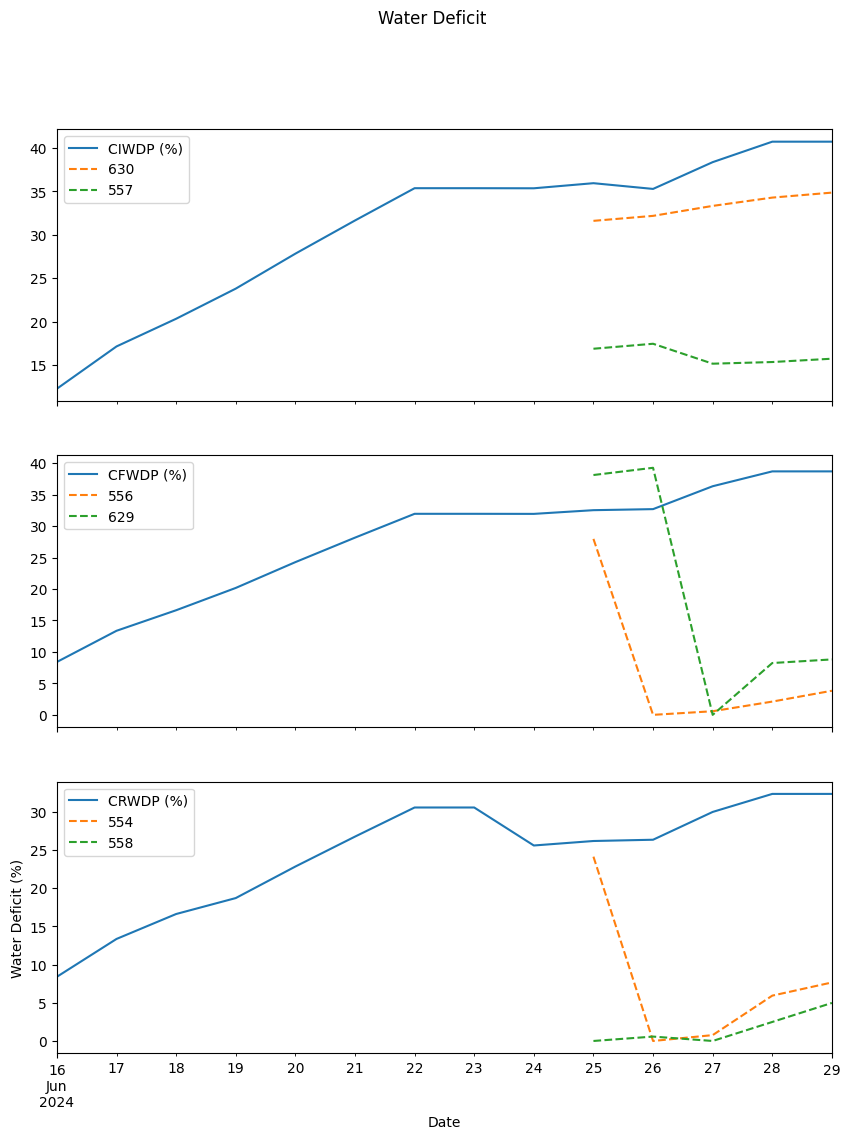

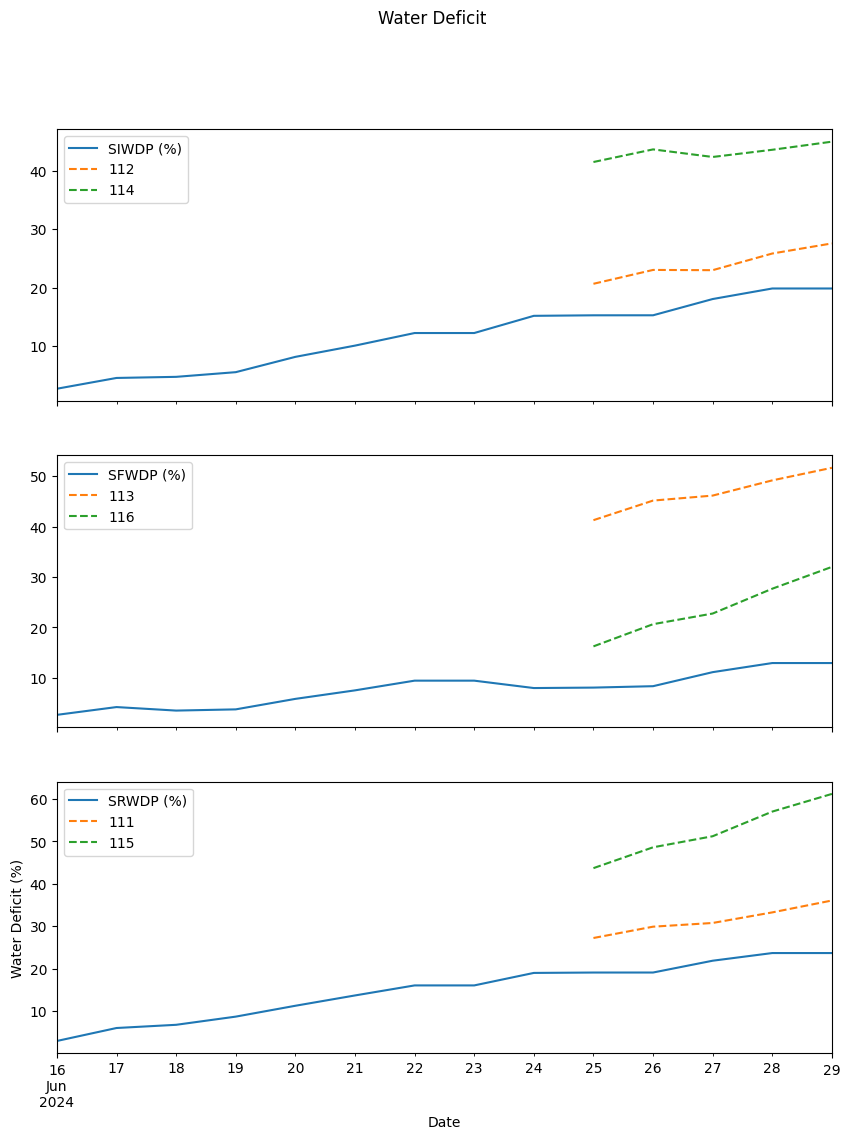

,AVG_WS (mps),precip (mm),SUM_SR (W/m²),AVG_Temp (°C),AVG_RH (%),SVP (kPa),VP (mb),HeatFlux (MJ/m²/day),Jdate,AP (kPa),...,CFWL (inch),SFWL (inch),CRWL (inch),SRWL (inch),CIWDP (%),SIWDP (%),CFWDP (%),SFWDP (%),CRWDP (%),SRWDP (%)
2024-06-25,3.4841,2.032,84.3333,23.8611,71.3125,2.9591,21.1023,0.4167,176.0,97.576,...,0.0000,0.0000,0.0000,0.0000,35.9531,15.2446,32.5344,8.0721,26.1896,19.0900
2024-06-26,1.6187,1.524,143.7917,22.7998,79.7083,2.7756,22.1238,0.4167,177.0,97.567,...,0.0000,0.0000,0.0000,0.0000,35.2919,15.2481,32.7008,8.3515,26.3560,19.0936
2024-06-27,2.2156,0.000,386.1042,20.3530,71.3542,2.3899,17.0527,0.4167,178.0,97.547,...,0.0000,0.0000,0.0000,0.0000,38.3794,18.0323,36.3400,11.1357,29.9952,21.8778
2024-06-28,1.9707,0.000,165.9792,23.2488,69.6042,2.8520,19.8511,0.4167,179.0,97.571,...,0.0000,0.0000,0.0000,0.0000,40.7412,19.8393,38.7018,12.9427,32.3570,23.6847
2024-06-29,3.5099,22.860,233.0606,25.9057,82.9394,3.3428,27.7246,0.4167,180.0,97.592,...,0.7501,0.7853,0.7501,0.7853,40.7412,19.8393,38.7018,12.9427,32.3570,23.6847


In [11]:
#* Main Code Block
# indata = read_hly('Table (5-min).csv')
filename = "./12_API_Weather_data/API_Weather_"+today+".csv"
# get the weather data from the earlier date between CED and SED

# ! =================================================
# ! conduct penman-montieth model                   =
# ! =================================================
# Calculate the potential evapotranspiration (ETo) using Penman-Monteith model
# * 1. get the 30 min weather data from API and aggregate to hourly data
# raw input the weather data method by user, if 1, run get_weather, if 2 use the data from the root directory
method = input("Enter the method to get the weather data.\n_______ 1) API.\n_______ 2) Downloaded Mesonet data: ")

# * 1.1. User will choose the method to get the weather data
# * 1) Download the weather data from the API
# * 2) Use the Mesonet data downloaded manually from the website and should be located in the 13_Mesonet_data folder
if method == '1':
    print ('Downloading the weather data from the API')
    get_weather(filename, min(CED, SED))
    indata = read_30min(filename)
elif method == '2':
    print ('Using the Mesonet data')
    indata = get_Mesonet()


dlydata = subhly2dly(indata)

# * 2.1 get heatflux
dlydata = get_heatflux(dlydata)

# * 2.2 run the penman monteith model
dlydata = PET_Penman (dlydata)


# * 3. Get the crop efficiency
# * 3.1 get weeks past emergence
dlydata = get_weeks_past_emergence(dlydata)


# ! =================================================
# ! calculate the water balance                     =
# ! =================================================
# calculate the water balance for corn and soybean

# * 3.2 calculate the ETc for corn and soybean
#      get crop coefficient from excel file and estimate ETc
dlydata = get_ETc(dlydata)

# * 3.3 Get the soil moisture data for the updawrad flux calculation
UFdf = read_L4df(f"./14_L4_Soilmoisture_data/SM-Layer4_{today}.csv")
dlydata = get_UF(UFdf, dlydata)

# * 4. Get the available water capacity
# * 4.1 calculate the irrigation for corn and soybean
#      get the irrigation log from the excel file named 'Irrigation_log.xlsx' from root folder
dlydata = get_irrlog(dlydata)

# * 4.2 calculate the root zone depth according to the week from emergence
#      calculate the available water holding capacity for corn and soybean
#      get rootzone depth for corn and soybean
#      dlydata = get_rootzone(dlydata) #! this is old version
dlydata = cal_rz() #! this is new version
#      calculate the available water holding capacity of the root zone for corn and soybean
dlydata = get_AWHCrz(dlydata)
#      calculate upward flux using the soil moisture data
#      get_UF()

# * 5. Get the Water Loss from updated Water Deficit
dlydata = get_deficit(dlydata)
get_deficit_graph(dlydata)



# save the data
dlydata = dlydata.round(4)
outfilename = './Penman_irrigation_results.csv'
summaryfilename = './Penman_irrigation_summary.csv'
dlydata.to_csv(outfilename, encoding = "utf-16", sep='\t')
dlydata.to_excel(outfilename.replace('.csv','.xlsx'), sheet_name='Penman_irrigation_results', freeze_panes=(1,1))

# export the data only needed, not the whole data
# precip, irrgation, fertigation, water deficit (inch) needed
dlydata2 = dlydata[['precip (mm)', 'CIRR (inch)', 'SIRR (inch)', 'CFRT (inch)', 'SFRT (inch)', 'CIWD (inch)', 'SIWD (inch)', 'CFWD (inch)', 'SFWD (inch)', 'CRWD (inch)', 'SRWD (inch)', 'CIWDP (%)', 'SIWDP (%)', 'CFWDP (%)', 'SFWDP (%)', 'CRWDP (%)', 'SRWDP (%)']]
dlydata2.to_excel(summaryfilename.replace('.csv','.xlsx'), sheet_name='Penman_irrigation_summary', freeze_panes=(1,1))

dlydata.tail()

# Appendix
***
### Parameters for the Penman-Montieth euqation

In this script, all the names are with the unit. If there is no unit, it means its fraction (0-1).\
Below table is description of the variable in the dlydata dataframe.\
`Weather input or data downloaded from Mesonet will be different header from dataframe.`
|Name|Unit|Description|
|:---:|:---:|--------------|
||||
|AVG_WS|mph|Average wind speed|
|precip|mm|Precipitation|
|SUM-SR|W/m²|Sum of solar radiation|
|AVG_Temp|°C|Average temperature of the day|
|AVG_RH|%|Relative humidity|
|SVP|kPa|Saturation vapor pressure|
|VP|kPa|Vapor pressure|
|HeatFlux|MJ/m²/day|Heat flux|
|Jdate|Date(0-365)|Julian date of the day from first day of that year|
|AP|kPa|Atmospheric pressure|
|gamma|---|---|
|VPD|kPa|Vapor pressure deficit|
|VPS|kPa|Vapor pressure curve slope|
|Rnet|MJ/m²/day|Net radiation at the crop surface|
|ETo|inch|Evapotranspiration|
|Week|---|Number of current week|
|CWPE|---|Number of week past corn's emergence (from CED)|
|SWPE|---|Number of week past soybean's emergence (from SED)|
|CKc|fraction|Crop Coefficient for specific week of corn|
|SKc|fraction|Crop Coefficient for specific week of soybean|
|CET|inch|Corn Evapotranspiration = ETo * CKC|
|SET|inch|Soybean Evapotranpiration = ETo * SKC|
|CRZ|inch|Corn Root Zone Depth|
|SRZ|inch|Soybean Root Zone Depth|
|CIRR|inch|Irrigation depth for the Corn|
|SIRR|inch|Irrigation depth for the Soybean|
|CFRT|inch|Fertigation depth for the Corn|
|SFRT|inch|Fertigation depth for the Corn|
|AWHC|inch|Available Water Holding Capacity of Root Zone for the Corn|
|AWHS|inch|Available Water Holding Capacity of Root Zone for the Soybean|
|||***Duplicated variables for the different managements BELOW***|
|||***CI=Corn IRR, SI=Soybean IRR, CF=Corn FERT, SF=Soyean FERT, CR=Corn RAIN, SR=Soybean RAIN***|
|**00+UF**|inch|Upward Flux from 4th layer for different Managements (-ve means water loss)|
|**00+WD**|inch|Water deficit for different Managements|
|**00+WL**|inch|Water loss for different Managements|
|**00+WDP**|%|Water deficit percentage for different managements|
||||
||||

### Below are reference for the future work.


Original source for the calculating ATPressure
```python
import math

def calculate_pressure(elevation, temperature):
    # Constants
    R = 8.31447  # Ideal gas constant (J/(mol·K))
    g = 9.80665  # Standard acceleration due to gravity (m/s^2)
    M = 0.0289644  # molar mass of Earth's air (kg/mol)

    # Convert temperature to Kelvin
    T = temperature + 273.15  # Convert Celsius to Kelvin

    # Calculate pressure
    pressure = (1e5) * math.exp((-g * M * elevation) / (R * T))
    
    return round(pressure/1000,3)  # Convert Pa to kPa and round to 4 decimal places

# Test the function
temperature = float(input("Enter the temperature (in Celsius): "))

pressure = calculate_pressure(213.36, temperature)
print(f"The pressure at 213.36 m elevation and {temperature}°C is {pressure} kPa")
```